In [ ]:
import numpy as np 
import pandas as pd 
import os
import keras
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout ,RepeatVector ,Lambda
from keras.models import Sequential
from keras.backend import expand_dims, repeat_elements
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from imutils import paths
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Lambda
from keras.layers import LSTM, RepeatVector,TimeDistributed,GlobalAveragePooling2D,BatchNormalization
from sklearn.utils import shuffle

# Generate auth tokens for Colab
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [ ]:
datagen = ImageDataGenerator( 
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest") 

width,height=150,150

print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/drive/My Drive/FMD/dataset/'))
#imagePaths = list(paths.list_images('/content/drive/My Drive/data/minidataset/dataset/'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
  # extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]
  image = load_img(imagePath, target_size=(width, height),color_mode='rgb')

  image = img_to_array(image)
  x = image.reshape((1, ) + image.shape)
  frameslist=[]
  count=0
  for batch in datagen.flow(x): 
    batch=batch.reshape(width, height, 3)
    if count == 0:
      frameslist.append(image)
    else:
      frameslist.append(batch)
    count += 1
    if count > 3: 
        break
    image=np.array(frameslist)
    
    # update the data and labels lists, respectively
  data.append(image)
  labels.append(label)
 

[INFO] loading images...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

#normalizing data
data=data/255.0
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data, labels = shuffle(data, labels)
print(data.shape)
print(labels.shape)

data=data.reshape(data.shape[0],data.shape[1],data.shape[2]*data.shape[3]*data.shape[4])
print(data.shape)
print(labels.shape)

(3830, 3, 150, 150, 3)
(3830, 2)
(3830, 3, 67500)
(3830, 2)


In [ ]:

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

# construct the training image generator for data augmentation

print("trainX:",x_train.shape)
print("testX:",x_test.shape)
print("valX:",x_val.shape)
print("trainY:",y_train.shape)
print("testY:",y_test.shape)
print("valY:",y_val.shape)


trainX: (2872, 3, 67500)
testX: (384, 3, 67500)
valX: (574, 3, 67500)
trainY: (2872, 2)
testY: (384, 2)
valY: (574, 2)


In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32


# bulid model
model = Sequential()
model.add(LSTM(128, input_shape=(data.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))


opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 


In [ ]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(x_train,y_train,
	            validation_data=(x_val, y_val),
	            epochs=EPOCHS)

print("Done !!")

[INFO] training head...
Epoch 1/20
90/90 [==============================] - 49s 549ms/step - loss: 0.9506 - accuracy: 0.5898 - val_loss: 0.4842 - val_accuracy: 0.8153
Epoch 2/20
90/90 [==============================] - 51s 568ms/step - loss: 0.5090 - accuracy: 0.7535 - val_loss: 0.4015 - val_accuracy: 0.8449
Epoch 3/20
90/90 [==============================] - 50s 556ms/step - loss: 0.4250 - accuracy: 0.8172 - val_loss: 0.3282 - val_accuracy: 0.8746
Epoch 4/20
90/90 [==============================] - 50s 555ms/step - loss: 0.3665 - accuracy: 0.8593 - val_loss: 0.2902 - val_accuracy: 0.9059
Epoch 5/20
90/90 [==============================] - 49s 542ms/step - loss: 0.3275 - accuracy: 0.8760 - val_loss: 0.2702 - val_accuracy: 0.9077
Epoch 6/20
90/90 [==============================] - 49s 542ms/step - loss: 0.3154 - accuracy: 0.8785 - val_loss: 0.4165 - val_accuracy: 0.8066
Epoch 7/20
90/90 [==============================] - 49s 542ms/step - loss: 0.3107 - accuracy: 0.8757 - val_loss: 0.245

In [ ]:
model.save("/content/drive/My Drive/FMD/Models/3frames150RNN.h5")

[INFO] evaluating network...

Confusion Matrix:-


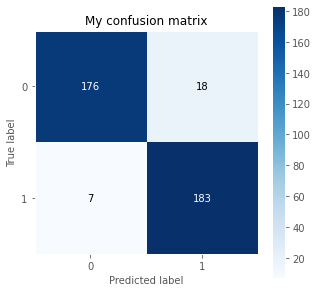


Classification Report:-
              precision    recall  f1-score   support

   with_mask       0.96      0.91      0.93       194
without_mask       0.91      0.96      0.94       190

    accuracy                           0.93       384
   macro avg       0.94      0.94      0.93       384
weighted avg       0.94      0.93      0.93       384


Testing Accuracy Score:- 93.48958333333334

Traning and Validation Flow:- 


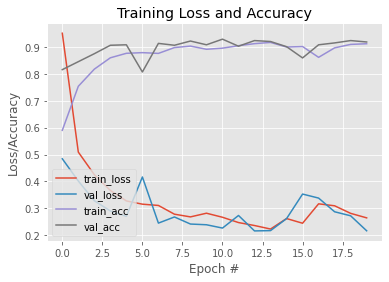

In [ ]:
#!pip install scikit-plot
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt
from sklearn.metrics import accuracy_score

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print("\nConfusion Matrix:-")
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), predIdxs, figsize = (5, 5), title= 'My confusion matrix' )
plt.show()

print("\nClassification Report:-")
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs,target_names=lb.classes_))
#for key in H.history.keys():
 #   print(key)

print("\nTesting Accuracy Score:-",accuracy_score(predIdxs,y_test.argmax(axis=1))*100)

print("\nTraning and Validation Flow:- ")
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

#plt.savefig()
